### Integrantes
<ul>
<li>Sebastián Aranda 201104560-2</li>
<li>Felipe Santander 201104xxx-x</li>
</ul>

# Fronteras de Clasificación

A continuación se presenta un dataset sintético en 2 Dimensiones donde la frontera de clasificación para ambos conjuntos de datos no es lineal.
Se agrega un parámetro de ruido para ir variando la instancia de clasificación y así analizar el comportamiento de distintas Fronteras de Clasificación.

In [36]:
import pandas as pd
import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

##### Manifold
Producido desde dos distribuciones:
<ul>
<li>Distribución multivariada gaussiana</li>
<li>Funciones senos y cosenos</li>
</ul>

Para cada distribución se generan 500 ejemplos.

Shape Datos1:  (500, 2)
Shape Datos2:  (500, 2)


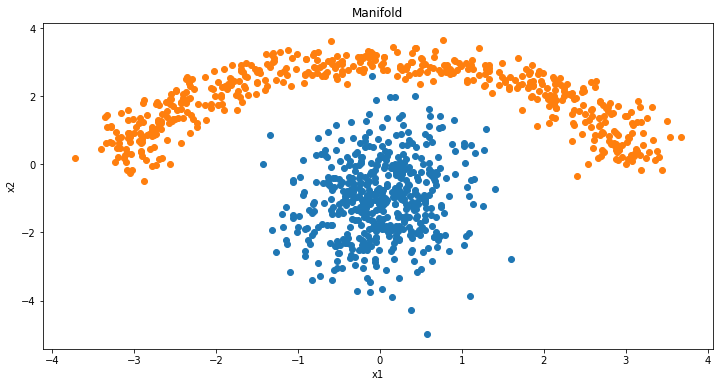

In [37]:
n_samples=500

#Generating Multivariate Normal Distribution
#mean = (0,-4)
#mean = (0,-3)
#mean = (0,-2)
mean = (0,-1)
C = np.array([[0.3, 0.1], [0.1, 1.5]])
datos1 = np.random.multivariate_normal(mean, C, n_samples)

#Generating Halfmoon Distribution
outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
datos2 = np.vstack((outer_circ_x,outer_circ_y)).T
generator = check_random_state(10)
datos2 += generator.normal(scale=0.3, size=datos2.shape)

print "Shape Datos1: ", datos1.shape
print "Shape Datos2: ", datos2.shape

x1,y1 = datos1.T
x2,y2 = datos2.T

plt.figure(figsize=(12,6))
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.title("Manifold")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

A continuación se agrega un parámetro de ruido para agregar más complejidad de clasificación al conjunto de datos. Según la magnitud de ruido escogida se realiza un shift de datos desde un conjunto a otro.

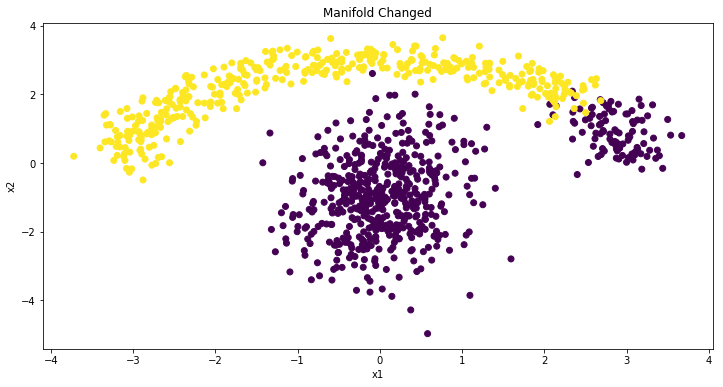

Dataset 1 Size: 600
Dataset 2 Size: 400


In [38]:
X = np.concatenate((datos1, datos2), axis=0)
#y = [i%2 for i in range(len(datos1)+len(datos2))] #No linear separable

n = 100 #Noise
y1 = np.zeros(datos1.shape[0]+n)
y2 = np.ones(datos2.shape[0]-n)
y = np.concatenate((y1,y2),axis=0)

plt.figure(figsize=(12,6))
plt.scatter(X[:,0],X[:,1], c=y)
plt.title("Manifold Changed")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

print "Dataset 1 Size:", len(y1)
print "Dataset 2 Size:", len(y2)

A continuación se presentan las fronteras de clasificación de dos modelos generativos LDA y QDA

In [39]:
import matplotlib.pyplot as plt
from ipywidgets import interactive
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix

def visualize_border(model,x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

    
def visualize_border_interactive_noise(noise):
    y1 = np.zeros(datos1.shape[0]+noise)
    y2 = np.ones(datos2.shape[0]-noise)
    y = np.concatenate((y1,y2),axis=0)
    
    mTest_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=mTest_size, random_state=0)
    
    model_lda = LDA()
    model_qda = QDA()
        
    model_lda.fit(X_train,y_train)
    model_qda.fit(X_train,y_train)
    visualize_border(model_lda,X,y,"LDA trained with %.2f"%(1-mTest_size)+" of the data")
    visualize_border(model_qda,X,y,"QDA trained with %.2f"%(1-mTest_size)+" of the data")
    y_pred_lda = model_lda.predict(X_test)
    y_pred_qda = model_qda.predict(X_test)
    print("Miss Classification Loss of LDA: %.2f"%(1-accuracy_score(y_test, y_pred_lda)))
    print("Miss Classification Loss of QDA: %.2f"%(1-accuracy_score(y_test, y_pred_qda)))
    
    print("Confusion Matrix of LDA")
    print(confusion_matrix(y_test, y_pred_lda))
    
    print("Confusion Matrix of QDA")
    print(confusion_matrix(y_test, y_pred_qda))
    
interactive(visualize_border_interactive_noise,noise=(0,500))

##### LDA
En Linear Discriminant Analysis (LDA) se construye una frontera de clasificación lineal modelando las densidades de las clases:

\begin{equation}
f_k(x) = P(G=k|X=x) = E(Y_k|X)
\end{equation}

En otras palabras, se define la densidad de clases como $f_k(x)$ correspondiente a la densidad condicional de $X$ dado $G = k$. Eesta densidad utilizando una Distribución Multivariada Gaussiana (DMG):

\begin{equation}
f_k(x) = \frac{1}{(2\pi)^{p/2}|\Sigma_k|^{1/2}}e^{-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}
\end{equation}

En particular LDA asume que las clases poseen la misma matriz de covarianza, es decir $\Sigma_k=\Sigma \quad \forall k$. Gracias a esta suposición la comparación de dos clases $k$ y $l$ resulta en una ecuación lineal en $x$ y $p$ al utilizar log-ratio:

\begin{equation}
\begin{split}
log\frac{P(G=k|X=x)}{P(G=l|X=x)}&=log\frac{f_k(x)}{f_l(x)}log\frac{\pi_k}{\pi_l}\\
&=log\frac{\pi_k}{\pi_l}-\frac{1}{2}(\mu_k+\mu_l)^T\Sigma^{-1}(\mu_k-\mu_l)\\
&\quad+x^T\Sigma^{-1}(\mu_k-\mu_l)
\end{split}
\end{equation}

Siendo las funciones discriminantes:

\begin{equation}
\delta_k(x) = x^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k+log\pi_k
\end{equation}

##### QDA
Para el caso de Quadratic Discriminant Analysis (QDA), el proceso para generar la frontera de clasificación es el mismo excepto que no se realiza la suposición de que las matrices de covarianza de las clases son iguales, aquí se asumen distintas y por lo tanto no se eliminan los términos cuadráticos de la ecu, quedando las funciones discriminantes:

\begin{equation}
\delta_k(x) = -\frac{1}{2}log|\Sigma_k|-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)+log\pi_k
\end{equation}

##### Análisis Cuantitativo

En términos cuantitativos, y para este dataset, uno esperaria que QDA tuviese un menor error de predicción debido a que su frontera de clasificación es cuadrática, y en el dataset propuesto se aprecia claramente que la frontera de decisión no puede ser lineal para clasificar todo con exactitud. En efecto esto se puede apreciar al ir variando el hiper-parámetro \textit{noise}, mientras mayor sea el valor de \textit{noise} la frontera para clasificar se vuelve lineal, lo que se ve reflejado en el error de clasificación.

### Accuracy:

\begin{equation}
\frac{TP+TN}{TP+TN+FP+FN}
\end{equation}

Valores para el caso de $noise=0$:
<pre>
Miss Classification Loss of LDA: 0.12
Miss Classification Loss of QDA: 0.03
</pre>

### <a href="https://en.wikipedia.org/wiki/Confusion_matrix">Confusion Matrix</a>
<pre>
Confusion Matrix of LDA
[[129  15]
 [ 22 134]]
Confusion Matrix of QDA
[[136   8]
 [  0 156]]
 </pre>

##### Logistic Regression, SVM, Classification Tree & KNN

En la presente sección se analizarán los parámetros de regularización para distintos algoritmos de clasificación. 

In [40]:
mTest_size = 0.3

In [41]:
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=mTest_size, random_state=0)
    y_pred = model.predict(X_test)
    print("Miss Classification Loss: %.2f"%(1-accuracy_score(y_test, y_pred)))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

In [42]:
from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=mTest_size, random_state=0)
    model.fit(X_train,y_train)
    return model

p_min = 1 #define your range
p_max = 10000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

In [43]:
from sklearn.svm import SVC as SVM
#SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='linear')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 10000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

In [44]:
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='rbf')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 10000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

In [45]:
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='poly')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 10000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de profundidad del árbol de decisión

In [47]:
from sklearn.tree import DecisionTreeClassifier as Tree
def train_model(param):
    model = Tree()#edit the train_model function
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 30 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Analizar valores del parámetro de k del algoritmo de clasificación K-NN

In [48]:
from sklearn.neighbors import KNeighborsClassifier
def train_model(param):
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(X,y)
    return model

p_min = 1 #define your range
p_max = 50 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

# Análisis de Audio - Datos Brutos

### <a href="https://www.kaggle.com/kinguistics/heartbeat-sounds">Heartbeat-sounds Kaggle</a>

A continuación se realizará un procesamiento de datos crudos para luego poder realizar tareas de clasificación con distintos algoritmos como Logistic Regression, SVM y Decision Trees. Dentro del trabajo de procesamiento de datos crudos se utiliza una herramienta de reducción de dimensionalidad llamada PCA.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
from scipy.io import wavfile

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name

SAMPLE_RATE = 44100
def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

In [51]:
df = pd.read_csv('./heartbeat-sounds_dataset/set_a.csv')
df.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [52]:
df['label'].value_counts(dropna=False)

NaN         52
artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64

A continuación se realiza un "padd de ceros", en otras palabras se estandariza la dimensionalidad de las series de tiempo ya que en principio poseen distintos largos. Este paso es importante porque más adelante el espacio de características (X) estará conformado por estas series de tiempo, y por tanto deben poser la misma cantidad de columnas $(p+1)$, considerando el intercepto. 

In [53]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux

new_df =pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='heartbeat-sounds_dataset/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))
print("DataFrame Edit Ok")

DataFrame Edit Ok


### <a href="https://www.kaggle.com/toregil/new-labels-for-set-a">New labels for set a</a>

Cambiar Labels 

In [54]:
new_labels =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
             1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0,
             2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0,
             0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

Cambiar clases a valores numéricos para ser trabajados por los clasificadores

In [55]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

In [56]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

(176, 396900)

Del bloque de código anterior se obtiene la dimensionalidad de $X$. Se puede apreciar que la cantidad de columnas es casi 400.000. Si no se realiza algún tipo de pre procesmiento el algoritmo se volvera extremádamente complejo y se verá afectado por "La Maldición de la Dimensionalidad", cayendo por tanto en \textit{overfiting}. Para solucionar este problema, se procesa la secuencia de tiempo utilizando una <a href="https://en.wikipedia.org/wiki/Fourier_transform">transformada de fourier discreta</a> para pasar los datos desde el dominio de tiempos al de frecuencias, presentes en la señal de sonido; de esta manera se reduce la dimensionalidad considerablemente.

In [57]:
from scipy import signal

X_fourier = np.abs(np.fft.fft(X))

X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)

X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

Del bloque de código anterior se aprecia una reducción del orden de un 75%

##### Hold-out Validation

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.25, random_state=42)

#Standarization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

print "X_train.shape: ", X_train.shape
print "y_train.shape: ", y_train.shape

In [ ]:
#PCA
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

print "PCA X_train.shape: ", X_pca_train.shape
plt.figure(figsize=(12,6))
plt.plot(X_pca_train[:,0], X_pca_train[:,1])
plt.show()

Construir gráfico de error de entrenamiento y testeo en función del hiper-parámetro de regularización C para un modelo de Regresión Logística y para otro de SVM con kernel lineal

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.model_selection import train_test_split

Cs = [0.0001,0.01,0.1,1,10,100,1000]

e_train = []
e_test = []
for c in Cs:
    model = LR()
    model.set_params(C=c,penalty='l2')
    model.fit(X_pca_train,y_train)
    e_train.append(model.score(X_pca_train,y_train))
    e_test.append(model.score(X_pca_test,y_test))
    
print("Logistic Regression Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Logistic Regression Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

e_train = []
e_test = []
for c in Cs:    
    model = SVM()
    model.set_params(C=c,kernel='linear')
    model.fit(X_pca_train,y_train)
    e_train.append(model.score(X_pca_train,y_train))
    e_test.append(model.score(X_pca_test,y_test))
    
print("SVM Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("SVM Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

from sklearn.tree import DecisionTreeClassifier as Tree

Depths = range(1,30)
e_train = []
e_test = []
for d in Depths:
    model = Tree()
    model.set_params(max_depth=d,criterion='gini',splitter='best')
    model.fit(X_pca_train,y_train)
    e_train.append(model.score(X_pca_train,y_train))
    e_test.append(model.score(X_pca_test,y_test))

print("Decision Tree Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Decision Tree Train and Test error for different depth parameters ")
plt.plot(Depths,e_train, label="train error")
plt.plot(Depths,e_test, label="test error")
plt.legend(loc=2)
plt.show()

Experimente con diferentes dimensiones <i>d</i> para la proyección de PCA con el propósito de obtener un modelo con menor error. Construya una tabla o grafico resumen

Realice otra reducción de dimensionalidad ahora a través de la técnica LDA, para representar los datos en <i>d</i> = 2 dimensiones. Recuerde que solo se debe ajustar con el conjunto de entrenamiento, si se muestra un warning explique el por qué. Visualice apropiadamente la proyección en 2 dimensiones.

In [ ]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_lda_train = model_lda.transform(X_train)
X_lda_test = model_lda.transform(X_test)

print "LDA X_train.shape: ", X_lda_train.shape
plt.figure()
plt.plot(X_lda_train[:,0], X_lda_train[:,1])
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.model_selection import train_test_split

Cs = [0.0001,0.01,0.1,1,10,100,1000]

e_train = []
e_test = []
for c in Cs:
    model = LR()
    model.set_params(C=c,penalty='l2')
    model.fit(X_lda_train,y_train)
    e_train.append(model.score(X_lda_train,y_train))
    e_test.append(model.score(X_lda_test,y_test))
    
print("Logistic Regression Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Logistic Regression Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

e_train = []
e_test = []
for c in Cs:    
    model = SVM()
    model.set_params(C=c,kernel='linear')
    model.fit(X_lda_train,y_train)
    e_train.append(model.score(X_lda_train,y_train))
    e_test.append(model.score(X_lda_test,y_test))
    
print("SVM Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("SVM Train and Test error for different C parameters ")
plt.plot(Cs,e_train, label="train error")
plt.plot(Cs,e_test, label="test error")
plt.legend(loc=2)
plt.show()

from sklearn.tree import DecisionTreeClassifier as Tree

Depths = range(1,30)
e_train = []
e_test = []
for d in Depths:
    model = Tree()
    model.set_params(max_depth=d,criterion='gini',splitter='best')
    model.fit(X_lda_train,y_train)
    e_train.append(model.score(X_lda_train,y_train))
    e_test.append(model.score(X_lda_test,y_test))

print("Decision Tree Error's Plot")
fig = plt.figure(figsize=(12,6))
plt.title("Decision Tree Train and Test error for different depth parameters ")
plt.plot(Depths,e_train, label="train error")
plt.plot(Depths,e_test, label="test error")
plt.legend(loc=2)
plt.show()

Con el propósito de encontrar el mejor modelo vuelva a realizar el item h) con el i) en el nuevo espacio generado por la representación según las <i>d</i> dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique

##### Feature Crafting

### <a href="https://www.kaggle.com/primaryobjects/voicegender">Voice Classification</a>

# Análisis de Emociones - Twitter

<a href="https://www.crowdflower.com/data-for-everyone/">Crowd Flower</a>